This Python code uses Thorlabs driver `WFS_32.dll` and requires that Python installation is **32-bit**. To install the driver run the [Thorlabs WFS Software](https://www.thorlabs.com/software_pages/ViewSoftwarePage.cfm?Code=WFS) installer.
Author: [Nikita Vladimirov](mailto:nikita.vladimirov@mdc-berlin.de)

In [1]:
import ctypes as ct
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#load the DLL:
wfs = ct.windll.WFS_32
byref = ct.byref

In [3]:
#Set the data types compatible with C DLL
byref = ct.byref
count = ct.c_int32() 
deviceID  = ct.c_int32()  
instrumentListIndex  = ct.c_int32() 
inUse = ct.c_int32() 
instrumentName = ct.create_string_buffer("", 256)
instrumentSN = ct.create_string_buffer("", 256)
resourceName = ct.create_string_buffer("", 256)
IDQuery = ct.c_bool()
resetDevice = ct.c_bool()
instrumentHandle = ct.c_ulong()
pupilCenterXMm = ct.c_double()
pupilCenterYMm = ct.c_double()
pupilDiameterXMm = ct.c_double()
pupilDiameterYMm = ct.c_double()
exposureTimeAct = ct.c_double()
masterGainAct = ct.c_double()
dynamicNoiseCut = ct.c_int32() 
calculateDiameters = ct.c_int32() 
cancelWavefrontTilt = ct.c_int32() 
errorMessage = ct.create_string_buffer("", 512)
errorCode = ct.c_int32()
pixelFormat = ct.c_int32()
pixelFormat.value = 0 #currently 8 bit only
camResolIndex = ct.c_int32()
spotsX = ct.c_int32()
spotsY = ct.c_int32()
wavefrontType = ct.c_int32() 
limitToPupil = ct.c_int32() 

In [4]:
#Set the parameter values
MAX_SPOTS_X = 50
MAX_SPOTS_Y = 40
arrayWavefront = np.zeros((MAX_SPOTS_Y,MAX_SPOTS_X),dtype = np.float32)
instrumentListIndex.value = 0 #0,1,2,, if multiple instruments connected
#Configure camera
camResolIndex.value = 1
# camResolIndex values:
# For WFS instruments: 
# Index  Resolution 
# 0    1280x1024          
# 1    1024x1024          
# 2     768x768            
# 3     512x512            
# 4     320x320 
# For WFS10 instruments: 
# Index  Resolution 
# 0     640x480          
# 1     480x480          
# 2     360x360            
# 3     260x260            
# 4     180x180 
# For WFS20 instruments: 
# Index  Resolution 
# 0    1440x1080             
# 1    1080x1080             
# 2     768x768               
# 3     512x512               
# 4     360x360               
# 5     720x540, bin2 
# 6     540x540, bin2 
# 7     384x384, bin2 
# 8     256x256, bin2 
# 9     180x180, bin2

#Set pupil
pupilCenterXMm.value = 0 #mm
pupilCenterYMm.value = 0 #mm
pupilDiameterXMm.value = 4.5 #mm
pupilDiameterYMm.value = 4.5 #mm

#Set spot calculation params
dynamicNoiseCut.value = 1
calculateDiameters.value = 0
cancelWavefrontTilt.value = 1


wavefrontType.value = 0
# This parameter defines the type of wavefront to calculate. 
# Valid settings for wavefrontType: 
# 0   Measured Wavefront 
# 1   Reconstructed Wavefront based on Zernike coefficients 
# 2   Difference between measured and reconstructed Wavefront 
# Note: Function WFS_CalcReconstrDeviations needs to be called prior to this function in case of Wavefront type 1 and 2.


limitToPupil.value = 1
# This parameter defines if the Wavefront should be calculated based on all detected spots or only within the defined pupil. 
# Valid settings: 
# 0   Calculate Wavefront for all spots 
# 1   Limit Wavefront to pupil interior

In [5]:
wfs.WFS_GetInstrumentListLen(None,byref(count))
print('WFS sensors connected: ' + str(count.value))

WFS sensors connected: 1


In [6]:
#Select a device and get its info
devStatus = wfs.WFS_GetInstrumentListInfo(None,instrumentListIndex, byref(deviceID), byref(inUse),
                             instrumentName, instrumentSN, resourceName)
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_GetInstrumentListInfo():' + str(errorMessage.value))
else:
    print('WFS deviceID: ' + str(deviceID.value))
    print('in use? ' + str(inUse.value))
    print('instrumentName: ' + str(instrumentName.value))
    print('instrumentSN: ' + str(instrumentSN.value))
    print('resourceName: ' + str(resourceName.value))

WFS deviceID: 1
in use? 0
instrumentName: WFS150-7AR
instrumentSN: M00313725
resourceName: USB::0x1313::0x0000::1


In [7]:
if not inUse.value:
    devStatus = wfs.WFS_init(resourceName, IDQuery, resetDevice, byref(instrumentHandle))
    if(devStatus != 0):
        errorCode.value = devStatus
        wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
        print('error in WFS_init():' + str(errorMessage.value))
    else:
        print('WFS has been initialized. Instrument handle: ' +str(instrumentHandle.value))
else:
    print('WFS already in use')

WFS has been initialized. Instrument handle: 167194704


In [8]:
#Configure camera
devStatus = wfs.WFS_ConfigureCam(instrumentHandle, 
                                 pixelFormat, camResolIndex, byref(spotsX), byref(spotsY))
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_ConfigureCam():' + str(errorMessage.value))
else:
    print('WFS camera configured')
    print('SpotsX:' + str(spotsX.value))
    print('SpotsY:' + str(spotsY.value))

WFS camera configured
SpotsX:29
SpotsY:29


In [9]:
devStatus = wfs.WFS_SetPupil(instrumentHandle,
                             pupilCenterXMm, pupilCenterYMm, pupilDiameterXMm, pupilDiameterYMm)
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_SetPupil():' + str(errorMessage.value))
else:
    print('WFS pupil set')

WFS pupil set


In [15]:
devStatus = wfs.WFS_TakeSpotfieldImageAutoExpos(instrumentHandle,
                                                byref(exposureTimeAct), byref(masterGainAct))
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_TakeSpotfieldImageAutoExpos():' + str(errorMessage.value))
else:
    print('Took spotfield image, auto exposure')
    print('exposureTimeAct, ms: ' + str(exposureTimeAct.value))
    print('masterGainAct: ' + str(masterGainAct.value))

Took spotfield image, auto exposure
exposureTimeAct, ms: 0.0793666666667
masterGainAct: 1.51921130595


In [16]:
devStatus = wfs.WFS_CalcSpotsCentrDiaIntens(instrumentHandle, dynamicNoiseCut, calculateDiameters)
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_CalcSpotsCentrDiaIntens():' + str(errorMessage.value))
else:
    print('WFS spot centroids calculated')

WFS spot centroids calculated


In [17]:
devStatus = wfs.WFS_CalcSpotToReferenceDeviations(instrumentHandle, cancelWavefrontTilt)
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_CalcSpotToReferenceDeviations():' + str(errorMessage.value))
else:
    print('WFS spot to ref deviations calculated')

WFS spot to ref deviations calculated


In [18]:
devStatus = wfs.WFS_CalcWavefront(instrumentHandle, 
                                  wavefrontType, limitToPupil, arrayWavefront.ctypes.data)
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_CalcWavefront():' + str(errorMessage.value))
else:
    print('WFS wavefront calculated')

WFS wavefront calculated


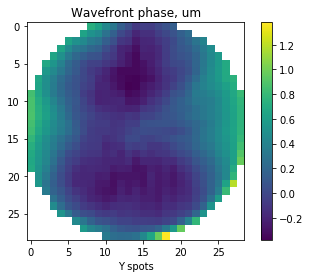

In [19]:
WF = arrayWavefront[:spotsY.value,:spotsX.value].copy()
plt.imshow(WF)
plt.title('Wavefront phase, um')
plt.xlabel('X spots')
plt.xlabel('Y spots')
plt.colorbar()

In [20]:
devStatus = wfs.WFS_close(instrumentHandle)
if(devStatus != 0):
    errorCode.value = devStatus
    wfs.WFS_error_message(instrumentHandle,errorCode,errorMessage)
    print('error in WFS_close():' + str(errorMessage.value))
else:
    print('WFS closed')

WFS closed
